In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Dense, Reshape, RandomFlip, RandomRotation, RandomBrightness, RandomContrast
from tensorflow.keras import Model, Input

2022-11-02 21:42:20.079305: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-02 21:42:20.237625: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-02 21:42:20.271163: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-02 21:42:21.036386: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

### TODOs

1. create randomly sampled training data
2. how to create heatmap?
3. Create test dataset - images or batches?
4. what's recommended way of creating dataset?
5. how to remove non-tissue area?
6. use multiple zoom levels
7. do I have to follow the paper?
8. how to use DeepZoom viewer?
9. what's the dir structure?

In [2]:
!gsutil ls gs://appliedeeplearning/

gs://appliedeeplearning/tumor_001.tif
gs://appliedeeplearning/tumor_001.xml
gs://appliedeeplearning/tumor_001_mask.tif
gs://appliedeeplearning/tumor_002.tif
gs://appliedeeplearning/tumor_002.xml
gs://appliedeeplearning/tumor_002_mask.tif
gs://appliedeeplearning/tumor_005.tif
gs://appliedeeplearning/tumor_005.xml
gs://appliedeeplearning/tumor_005_mask.tif
gs://appliedeeplearning/tumor_012.tif
gs://appliedeeplearning/tumor_012.xml
gs://appliedeeplearning/tumor_012_mask.tif
gs://appliedeeplearning/tumor_016.tif
gs://appliedeeplearning/tumor_016.xml
gs://appliedeeplearning/tumor_016_mask.tif
gs://appliedeeplearning/tumor_019.tif
gs://appliedeeplearning/tumor_019.xml
gs://appliedeeplearning/tumor_019_mask.tif
gs://appliedeeplearning/tumor_023.tif
gs://appliedeeplearning/tumor_023.xml
gs://appliedeeplearning/tumor_023_mask.tif
gs://appliedeeplearning/tumor_031.tif
gs://appliedeeplearning/tumor_031.xml
gs://appliedeeplearning/tumor_031_mask.tif
gs://appliedeeplearning/tumor_035.tif
gs://appli

### Define Global Variables

In [3]:
DATA_BATCH = 8
TRAIN_BATCH = 4
EPOCHS = 5
IMAGE_SIZE = 299
REGION_SIZE = 128
TRAINING_IMAGES = [("tumor_110.tif", "tumor_110_mask.tif")]
TEST_IMAGES = [("tumor_031.tif", "tumor_031_mask.tif")]

### Define Functions

In [4]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [5]:
def validate_openslide_objs(slide_obj, mask_obj):
    for i in range(len(slide_obj.level_dimensions)):
        assert mask_obj.level_dimensions[i][0] == slide_obj.level_dimensions[i][0]
        assert mask_obj.level_dimensions[i][1] == slide_obj.level_dimensions[i][1]

    # Verify downsampling works as expected
    width, height = slide_obj.level_dimensions[7]
    assert width * slide_obj.level_downsamples[7] == slide_obj.level_dimensions[0][0]
    assert height * slide_obj.level_downsamples[7] == slide_obj.level_dimensions[0][1]

In [6]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

In [7]:
def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

In [8]:
def extract_label(im, mask) -> int:
    """Extract label (0/1) from the center 128 x 128 of the im"""
    start_i = im.shape[0] // 2 - REGION_SIZE // 2
    end_i = start_i + REGION_SIZE
    start_j = im.shape[1] // 2 - REGION_SIZE // 2
    end_j = start_j + REGION_SIZE
    mask_slice = mask[start_i:end_i, start_j:end_j]
    return int(np.sum(mask_slice == 1) >= 1)

In [9]:
def augment_data(im: np.ndarray, mask: np.ndarray, training: list, labels: list):
    """Augment data"""
    temp = []
    for i in range(4):
        temp.append(tf.image.rot90(im, k=i+1))
    imflipped = tf.image.flip_left_right(im)
    for i in range(4):
        temp.append(tf.image.rot90(imflipped, k=i+1))
    # apply random transformations 
    # using data in the paper
    for img in temp:
        img = tf.image.random_brightness(img, max_delta=64/255)
        img = tf.image.random_saturation(img, lower=0, upper=0.25)
        img = tf.image.random_contrast(img, lower=0, upper=0.75)
        img = tf.image.random_hue(img, max_delta=0.04)
    training += temp
    labels += [extract_label(im, mask)] * 8
    return training, labels

In [10]:
def create_slices(im, mask, height, width, stride):
    """Create slices from im and mask
    
    Args:
        height: height of the slice
        width: width of the slice
        stride: how much to move per
    """
    assert im.shape[0] == mask.shape[0]
    assert im.shape[1] == mask.shape[1]
    h, w = im.shape[0], im.shape[1]
    training = []
    labels = []
    i = 0
    while i * stride + height < h:
        j = 0
        while j * stride + width < w:
            im_slice = im[i*stride: i*stride+height, j*stride: j*stride+width]            
            mask_slice = mask[i*stride: i*stride+height, j*stride: j*stride+width]
            # training, labels = augment_data(im_slice, mask_slice, training, labels)
            training.append(im_slice)
            labels.append(extract_label(im_slice, mask_slice))
            j += 1
        i += 1
    return np.array(training), np.array(labels)

In [11]:
def create_training_dataset(slide_path, tumor_mask_path, x, y, level, width, height, val_prop=0.2):
    slide, tumor_mask = open_slide(slide_path), open_slide(tumor_mask_path)
    slide_image = read_slide(slide, x, y, level, width, height).copy()
    mask_image = read_slide(slide, x, y, level, width, height)[:, :, 0].copy()
    slide_image /= 255
    
    X, y = create_slices(slide_image, mask_image, IMAGE_SIZE, IMAGE_SIZE)
    dataset = tf.data.Dataset.from_tensor_slices((X, y)).batch(BATCH_SIZE)
    n = len(X)
    
    val_dataset = dataset.take(int(n * val_prop))
    train_dataset = dataset.skip(n - int(n * val_prop))
    AUTOTUNE = tf.data.AUTOTUNE
    train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
    val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
    return train_dataset, val_dataset

In [12]:
def create_test_dataset(slide_path, tumor_mask_path, x, y, level, stride):
    slide, tumor_mask = open_slide(slide_path), open_slide(tumor_mask_path)
    slide_image = read_slide(slide, x, y, level, 
                             slide.level_dimensions[level][0], 
                             slide.level_dimensions[level][1])
    mask_image = read_slide(tumor_mask, x, y, level, 
                            tumor_mask.level_dimensions[level][0], 
                            tumor_mask.level_dimensions[level][1])[:, :, 0]
    slide_image = tf.cast(slide_image, tf.float32) / 255
    
    # now instead of setting stride = 299, we set stride = 128
    X, y = create_slices(slide_image, mask_image, height=IMAGE_SIZE, width=IMAGE_SIZE, stride=stride)
    dataset = tf.data.Dataset.from_tensor_slices((X, y)).batch(1)
    n = len(X)
    print(n)
    
    AUTOTUNE = tf.data.AUTOTUNE
    test_dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    return test_dataset

In [13]:
def make_inference(im: np.ndarray, test_dataset: tf.data.Dataset, model: tf.keras.Model):
    """Run inference across the slide in a sliding window
    with a stride of 128. For each patch, apply the rotations
    and left-right flip to obtain predictions for each of 
    the 8 orientations, and average the 8 predictions"""
    preds = []
    for X_test, y_test in test_dataset:
        pred = model.pred(X_test)
        preds.append(pred)
    return preds

### Load Data

In [14]:
slide_path = "tumor_110.tif"
tumor_mask_path = "tumor_110_mask.tif"

In [15]:
slide = open_slide(slide_path)
tumor_mask = open_slide(tumor_mask_path)

In [16]:
slide.level_dimensions

((94208, 71680),
 (47104, 35840),
 (23552, 17920),
 (11776, 8960),
 (5888, 4480),
 (2944, 2240),
 (1472, 1120),
 (736, 560),
 (368, 280))

In [17]:
slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=4, 
                         width=slide.level_dimensions[4][0], 
                         height=slide.level_dimensions[4][1])

mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=4, 
                        width=slide.level_dimensions[4][0], 
                        height=slide.level_dimensions[4][1])

mask_image = mask_image[:,:,0]

In [18]:
mask_image.shape

(4480, 5888)

In [19]:
slide_image.shape

(4480, 5888, 3)

### Preprocessing

#### Normalize

In [20]:
slide_image_normalized = tf.cast(slide_image, tf.float32) / 255

2022-11-02 21:42:27.262527: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-02 21:42:27.275515: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-02 21:42:27.276910: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-02 21:42:27.278324: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow 

In [21]:
assert mask_image.shape[0] == slide_image.shape[0]
assert mask_image.shape[1] == slide_image.shape[1]
IMG_SHAPE = slide_image.shape

#### Create Dataset

In [22]:
X, y = create_slices(slide_image_normalized, mask_image, IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE)
print(X.shape)
print(y.shape)

(266, 299, 299, 3)
(266,)


In [23]:
print(np.count_nonzero(y == 1))
print(np.count_nonzero(y == 0))

64
202


In [24]:
# setting batch_size = 1 -> each element becomes a batch
dataset = tf.data.Dataset.from_tensor_slices((X, y)).batch(1)
val_dataset = dataset.take(15)
train_dataset = dataset.skip(15)

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

In [25]:
for image, mask in train_dataset.take(2):
    print(image.shape)
    print(mask.shape)
    break

(1, 299, 299, 3)
(1,)


In [26]:
print(train_dataset)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


### Define Model

In [27]:
def train_data_augmentation(x):
    x = RandomRotation(0.25)(x)
    x = RandomRotation(0.5)(x)
    x = RandomRotation(0.75)(x)
    x = RandomFlip("horizontal")(x)
    x = RandomBrightness(factor=64/255)(x)
    x = RandomContrast(factor=0.75)(x)
    return x

In [28]:
def customized_model(image_size, classes):
    inputs = Input(shape=(image_size, image_size, 3))
    x = train_data_augmentation(inputs)
    base_model = tf.keras.applications.InceptionV3(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), 
                                                   include_top=False, 
                                                   weights='imagenet')
    x = base_model(inputs, training=False)
    x = Conv2D(filters=1, kernel_size=(3, 3), padding="same")(x)
    x = Reshape((64,))(x)
    outputs = Dense(1, activation="softmax")(x)
    model = Model(inputs, outputs, name="myModel")
    return model

In [29]:
model = customized_model(IMAGE_SIZE, 1)

In [30]:
model.summary()

Model: "myModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 conv2d_94 (Conv2D)          (None, 8, 8, 1)           18433     
                                                                 
 reshape (Reshape)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 21,821,282
Trainable params: 21,786,850
Non-trainable params: 34,432
_________________________________________________________________


### Compile Model

In [31]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(),
             keras.metrics.FalseNegatives(),
             keras.metrics.FalsePositives(),
             keras.metrics.AUC(),
             keras.metrics.Recall()]
)

### Train Model

In [32]:
history = model.fit(
    train_dataset, 
    epochs=EPOCHS,
    verbose=1,
    validation_data=val_dataset
)

Epoch 1/5


2022-11-02 21:42:46.372042: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-11-02 21:42:47.778598: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-11-02 21:42:47.780026: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2022-11-02 21:42:47.780071: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2022-11-02 21:42:47.780133: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be 

251/251 [==============================] - 32s 78ms/step - loss: 1584.6302 - binary_accuracy: 0.2550 - false_negatives: 0.0000e+00 - false_positives: 187.0000 - auc: 0.5000 - recall: 1.0000 - val_loss: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_false_negatives: 0.0000e+00 - val_false_positives: 15.0000 - val_auc: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
251/251 [==============================] - 17s 68ms/step - loss: 7220793.0000 - binary_accuracy: 0.2550 - false_negatives: 0.0000e+00 - false_positives: 187.0000 - auc: 0.5000 - recall: 1.0000 - val_loss: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_false_negatives: 0.0000e+00 - val_false_positives: 15.0000 - val_auc: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
251/251 [==============================] - 18s 72ms/step - loss: 795818304.0000 - binary_accuracy: 0.2550 - false_negatives: 0.0000e+00 - false_positives: 187.0000 - auc: 0.5000 - recall: 1.0000 - val_loss: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_f

### Plot Metrics

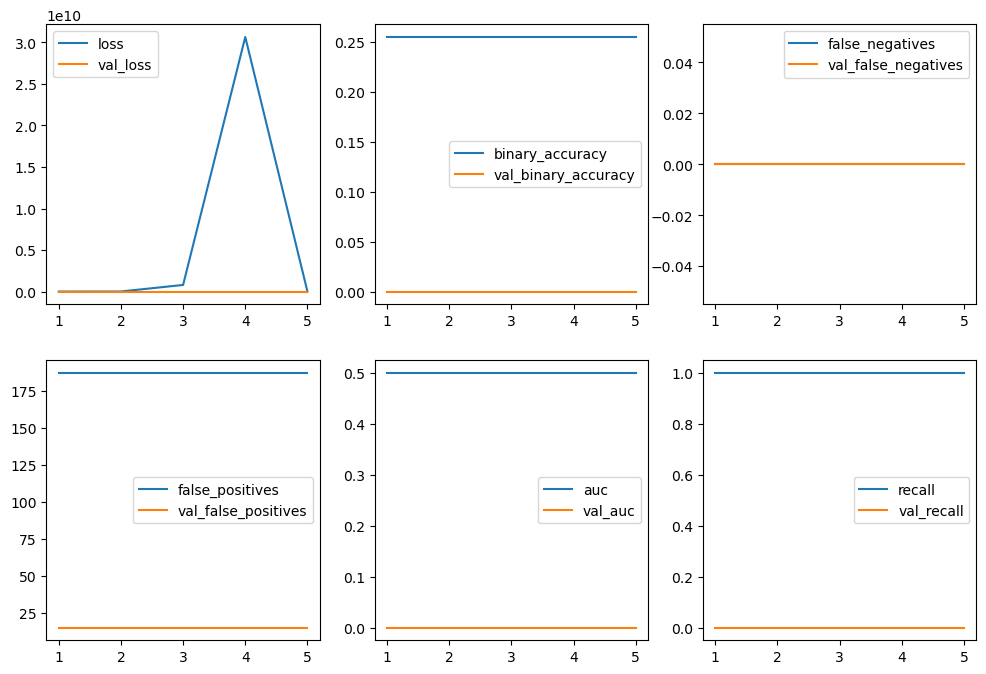

In [33]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
for i, ax in enumerate(axs.reshape(-1)):
    ax.plot(np.arange(1, EPOCHS+1), history.history[model.metrics_names[i]], label=model.metrics_names[i])
    ax.plot(np.arange(1, EPOCHS+1), history.history[f"val_{model.metrics_names[i]}"], label=f"val_{model.metrics_names[i]}")
    ax.legend()

### Make Prediction

In [34]:
X_test_sample = slide_image_normalized[8:8+299, 8:8+299]
X_test_sample = np.expand_dims(X_test_sample, 0)
X_test_sample.shape

(1, 299, 299, 3)

In [35]:
model.predict(
    X_test_sample
)

1/1 [==============================] - 1s 1s/step


array([[1.]], dtype=float32)

In [36]:
test_dataset = create_test_dataset(TEST_IMAGES[0][0], TEST_IMAGES[0][1], x=0, y=0, level=5, stride=REGION_SIZE)
test_dataset

1144


<PrefetchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [37]:
test_slide = open_slide(TEST_IMAGES[0][0])
test_mask = open_slide(TEST_IMAGES[0][1])
test_slide_img = read_slide(test_slide, 0, 0, 6, test_slide.level_dimensions[6][0], test_slide.level_dimensions[6][1])
mask_img = read_slide(test_mask, 0, 0, 6, test_mask.level_dimensions[6][0], test_mask.level_dimensions[6][1])
test_slide_img = tf.cast(test_slide_img, tf.float32) / 255
h, w = test_slide_img.shape[0], test_slide_img.shape[1]

In [40]:
stride = REGION_SIZE

heatmap_np = np.zeros((h, w))
i = 0
while i * stride + IMAGE_SIZE < h:
    j = 0
    while j * stride + IMAGE_SIZE < w:
        im = test_slide_img[i*stride:i*stride+IMAGE_SIZE, j*stride:j*stride+IMAGE_SIZE]
        
        # augmentation
        temp = []
        for i in range(4):
            temp.append(tf.image.rot90(im, i+1))
        flipped = tf.image.flip_left_right(im)

        for i in range(4):
            temp.append(tf.image.rot90(flipped, i+1))
        temp = np.array(temp)
        
        # pred
        y_preds = model.predict(temp, verbose=0)
        y_pred_avg = np.average(y_preds)
        
        # fill heatmap
        start_i = (i*stride+i*stride+IMAGE_SIZE)//2-REGION_SIZE//2
        end_i = (i*stride+i*stride+IMAGE_SIZE)//2-REGION_SIZE//2 + REGION_SIZE
        heatmap_np[start_i:end_i, start_i:end_i] = y_pred_avg
        
        j += 1
    i += 1

KeyboardInterrupt: 

### Plot Heatmap

In [ ]:
figure, axs = plt.subplots(1, 2, sharex=True, sharey=True)
axs[0].imshow(test_slide_img)
axs[1].imshow(heatmap_np)